# Klasyfikacja raka mózgu - Hubert Jaremko

## Sieć konwolucyjna

In [276]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

### Ustawienia

In [277]:
cancer_type = {0 : 'Oponiak', 1 : 'Glejak', 2 : 'Guz przysadki'}

In [278]:
# image_size = (512, 512)
# image_size = (224, 224)
# image_size = (128, 128)
image_size = (64, 64)
batch_size = 32

train_dir = "data/train"
val_dir = "data/val"

## Funkcje pomocnicze

In [279]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 7))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0, 1])
        plt.legend()

In [280]:
def plot_confusion_matrix(y_pred, y_true):
    plt.figure(figsize=(6, 5))
    cm = metrics.confusion_matrix(y_pred=predicted_classes, y_true=true_classes)
    sn.heatmap(cm, annot=True, fmt='g', cmap="RdPu")
    plt.show()

In [281]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

def binarize_labels(y_test):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return y_test

def multiclass_roc_auc_score(y_test, y_pred, c_ax, average="macro"):
    y_test = binarize_labels(y_test)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = f'{c_label} (AUC:{auc(fpr, tpr):0.2f})')

    c_ax.plot(fpr, fpr, '--', color = '0.75', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


def plot_roc_curve(y_test, y_pred):
    target = ['Oponiak', 'Glejak', 'Guz przysadki']
    fig, c_ax = plt.subplots(1, 1, figsize = (5, 3))

    print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred, c_ax))

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()


## Wczytanie zbioru testowego i walidacyjnego

*Augmentacja danych* - losowe odbijanie w poziomie i pionie oraz zmiana jasności obrazu.

In [282]:
train_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2)
#     brightness_range=(1.0, 2.0)
)

train_data_generator = train_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

train_steps_per_epoch = np.math.ceil(train_data_generator.samples / train_data_generator.batch_size)


Found 2450 images belonging to 3 classes.


In [283]:
test_generator = ImageDataGenerator()

test_data_generator = test_generator.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

Found 1500 images belonging to 3 classes.


### Próbka zbioru testowego

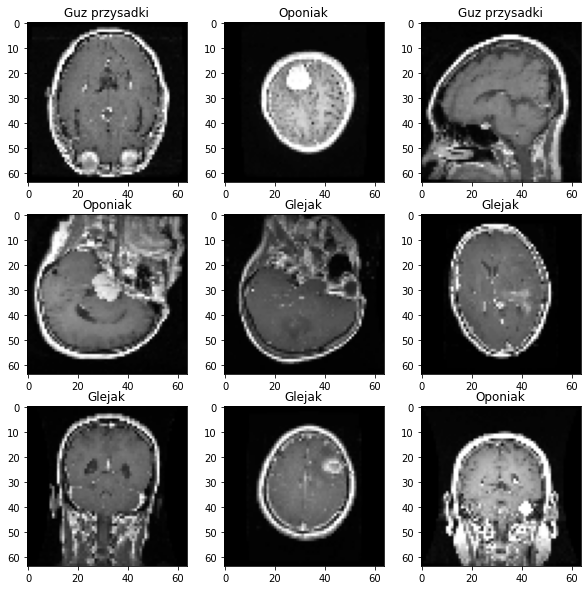

In [284]:
plt.figure(figsize=(10, 10))

b = next(train_data_generator)

images = b[0]
labels = b[1]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = images[i]
    label = labels[i]
    plt.imshow(image.astype("uint8"))
    label = cancer_type[np.argmax(label)]
    plt.title(label)

In [285]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Model
https://www.sciencedirect.com/science/article/pii/S2666827020300049

In [286]:
def make_lunet_model(input_shape):
    model = tf.keras.models.Sequential()

    model.add(layers.InputLayer(input_shape))
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation("elu"))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation("elu"))
    model.add(MaxPooling2D((3, 3)))
    model.add(Activation("elu"))

    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation("elu"))
    model.add(MaxPooling2D((3, 3)))
    model.add(Activation("elu"))

    model.add(UpSampling2D())
    model.add(Conv2D(6, (3, 3)))
    model.add(Conv2D(6, (3, 3)))
    model.add(Activation("elu"))

    model.add(UpSampling2D())
    model.add(Activation("elu"))
    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation("elu"))


    model.add(Flatten())
    model.add(Dense(128, activation="elu"))
    model.add(Dense(128, activation="elu"))
    model.add(Dense(3, activation="softmax"))
    return model

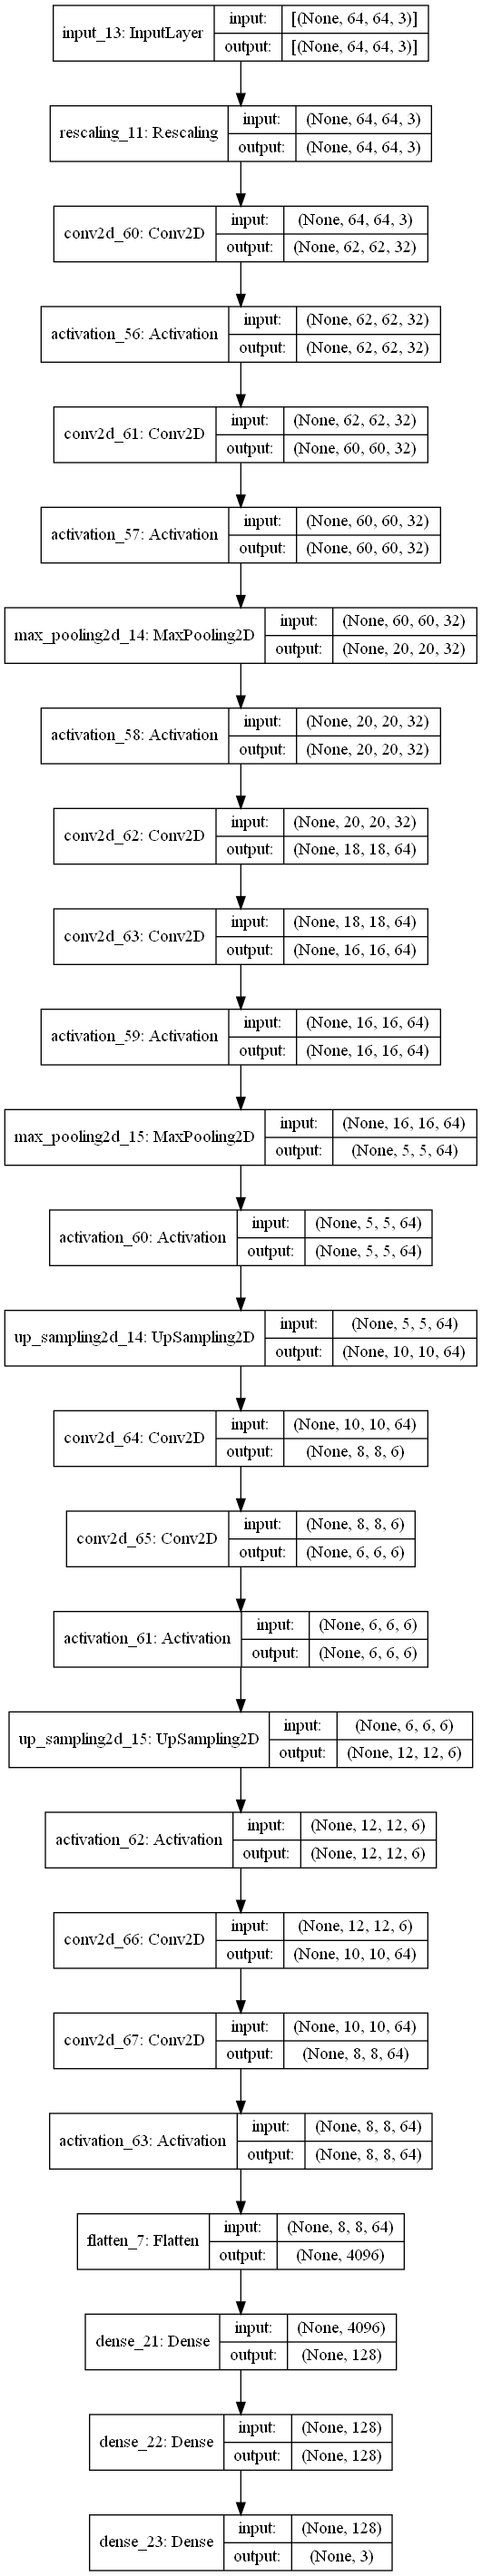

In [287]:
model = make_lunet_model(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)
# model.summary()

In [288]:
epochs = 32

history = History()

callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
]

model.compile(
#     optimizer=keras.optimizers.Adam(0.00001),
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=[
        "categorical_accuracy",
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ],
)

history = model.fit(
    train_data_generator,
    steps_per_epoch=train_steps_per_epoch,

    validation_data=test_data_generator,
    validation_steps=test_steps_per_epoch,

    epochs=epochs, 
    callbacks=callbacks, 
)

Epoch 1/32
77/77 [==============================] - 46s 554ms/step - loss: 0.8855 - categorical_accuracy: 0.6102 - precision: 0.6595 - recall: 0.5155 - auc: 0.7869 - val_loss: 0.7056 - val_categorical_accuracy: 0.6540 - val_precision: 0.6793 - val_recall: 0.5960 - val_auc: 0.8531
Epoch 2/32
77/77 [==============================] - 39s 511ms/step - loss: 0.6357 - categorical_accuracy: 0.7143 - precision: 0.7421 - recall: 0.6743 - auc: 0.8825 - val_loss: 0.6728 - val_categorical_accuracy: 0.6687 - val_precision: 0.6907 - val_recall: 0.6120 - val_auc: 0.8681
Epoch 3/32
77/77 [==============================] - 40s 524ms/step - loss: 0.5619 - categorical_accuracy: 0.7392 - precision: 0.7572 - recall: 0.7192 - auc: 0.9084 - val_loss: 0.7954 - val_categorical_accuracy: 0.6447 - val_precision: 0.6566 - val_recall: 0.6373 - val_auc: 0.8631
Epoch 4/32
77/77 [==============================] - 40s 519ms/step - loss: 0.5200 - categorical_accuracy: 0.7641 - precision: 0.7779 - recall: 0.7449 - auc: 

77/77 [==============================] - 46s 598ms/step - loss: 0.1640 - categorical_accuracy: 0.9404 - precision: 0.9422 - recall: 0.9376 - auc: 0.9917 - val_loss: 0.2306 - val_categorical_accuracy: 0.9133 - val_precision: 0.9156 - val_recall: 0.9113 - val_auc: 0.9861
Epoch 31/32
77/77 [==============================] - 53s 685ms/step - loss: 0.1513 - categorical_accuracy: 0.9461 - precision: 0.9480 - recall: 0.9453 - auc: 0.9928 - val_loss: 0.1920 - val_categorical_accuracy: 0.9340 - val_precision: 0.9357 - val_recall: 0.9320 - val_auc: 0.9886
Epoch 32/32
77/77 [==============================] - 45s 578ms/step - loss: 0.1313 - categorical_accuracy: 0.9547 - precision: 0.9554 - recall: 0.9535 - auc: 0.9940 - val_loss: 0.2765 - val_categorical_accuracy: 0.8920 - val_precision: 0.8925 - val_recall: 0.8907 - val_auc: 0.9788


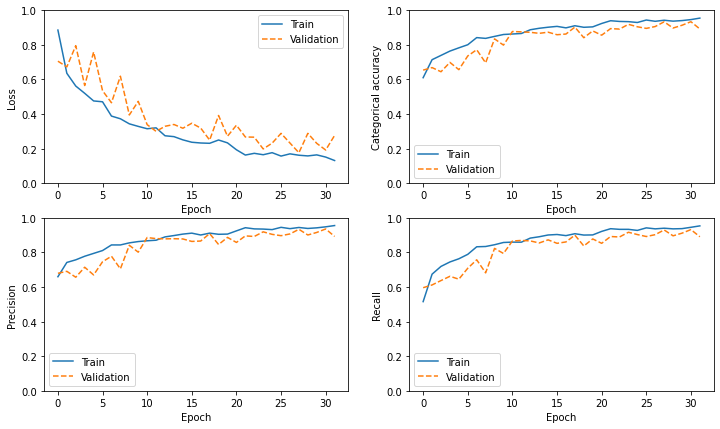

In [289]:
plot_metrics(history)

In [290]:
model.evaluate(test_data_generator)

47/47 [==============================] - 10s 214ms/step - loss: 0.2765 - categorical_accuracy: 0.8920 - precision: 0.8925 - recall: 0.8907 - auc: 0.97883s - loss: 0.4121 - categorical_accuracy: 0.8348 - precision: 0.8356 - recall: 


[0.27649787068367004,
 0.8920000195503235,
 0.8924515843391418,
 0.890666663646698,
 0.9788057208061218]

In [291]:
predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

In [292]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [293]:
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           1       0.95      0.74      0.83       500
           2       0.79      0.96      0.87       500
           3       0.97      0.98      0.97       500

    accuracy                           0.89      1500
   macro avg       0.90      0.89      0.89      1500
weighted avg       0.90      0.89      0.89      1500



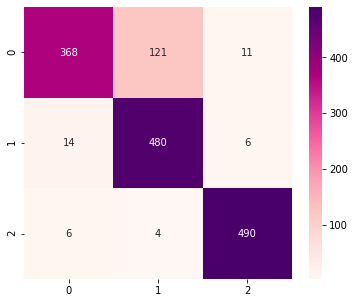

In [294]:
plot_confusion_matrix(predicted_classes, true_classes)

ROC AUC score: 0.984106


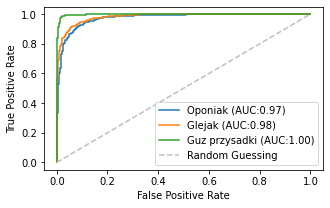

In [295]:
plot_roc_curve(true_classes, predictions)

In [296]:
def print_proba(score, i):
    print(
    f"{cancer_type[i]} : {score[i] * 100:0.2f}%"
)

In [297]:
img = keras.preprocessing.image.load_img(
    "data/val/3/13.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# print(img_array.shape)

predictions = model.predict(img_array)
score = predictions[0]
# print(score)
print_proba(score, 0)
print_proba(score, 1)
print_proba(score, 2)

Oponiak : 0.00%
Glejak : 0.00%
Guz przysadki : 100.00%
